### Context
Here we try to create an algorithm to maximise profit across the S&P500. This version of the model will only take use signals derived from historical prices as found in the data, `sp500.csv`. Here we add all imports and download the data:

In [65]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

In [66]:
# Define ticker and timeframe
ticker = "^GSPC"
start_date = (datetime.today() - timedelta(days=365 * 20)).strftime('%Y-%m-%d') # 5 years ago
end_date = datetime.today().strftime('%Y-%m-%d')

# Download and save to CSV
sp500 = yf.download(ticker, start=start_date, end=end_date)
sp500.to_csv("sp500_data.csv")
print("Saved to sp500_data.csv")
print(sp500.head())

/var/folders/t5/x93h4kds34110n67wlm59khw0000gn/T/ipykernel_43931/2072079055.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  sp500 = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed

Saved to sp500_data.csv
Price             Close         High          Low         Open      Volume
Ticker            ^GSPC        ^GSPC        ^GSPC        ^GSPC       ^GSPC
Date                                                                      
2005-08-01  1235.349976  1239.099976  1233.800049  1234.180054  1716870000
2005-08-02  1244.119995  1244.689941  1235.349976  1235.349976  2043120000
2005-08-03  1245.040039  1245.859985  1240.569946  1244.119995  1999980000
2005-08-04  1235.859985  1245.040039  1235.150024  1245.040039  1981220000
2005-08-05  1226.420044  1235.859985  1225.619995  1235.859985  1930280000


Here we load the dataframe and parse as necessary:

In [67]:
# Load the CSV
columns = ['Date', 'Close', 'High', 'Low', 'Open', 'Volume']
df = pd.read_csv("sp500_data.csv", skiprows=3, names=columns)

# Convert 'Date' to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Set 'Date' as index
df.set_index('Date', inplace=True)

# Display the first few rows
print(df.head())

                  Close         High          Low         Open      Volume
Date                                                                      
2005-08-01  1235.349976  1239.099976  1233.800049  1234.180054  1716870000
2005-08-02  1244.119995  1244.689941  1235.349976  1235.349976  2043120000
2005-08-03  1245.040039  1245.859985  1240.569946  1244.119995  1999980000
2005-08-04  1235.859985  1245.040039  1235.150024  1245.040039  1981220000
2005-08-05  1226.420044  1235.859985  1225.619995  1235.859985  1930280000


At this point we want to think about the signals that we want to use for our algorithm. Let us just define some of the more basic columns, such as `Daily Return` and `Cumulative Returns`.

In [68]:
# Calculate daily returns from 'Close'
df['Daily Return'] = df['Close'].pct_change() # pct_change() calculates the percentage change between the current and prior element
df['Log Return'] = np.log(df['Close'] / df['Close'].shift(1))  # Logarithmic returns
df['Cumulative Returns'] = (1 + df['Daily Return']).cumprod() - 1 
df['Volatility'] = df['Log Return'].rolling(window=30).std() # 30-day rolling volatility

df.dropna(inplace=True)  # Drop rows with NaN values

print(df.head())

                  Close         High          Low         Open      Volume  \
Date                                                                         
2005-09-13  1231.199951  1240.569946  1231.199951  1240.569946  2082360000   
2005-09-14  1227.160034  1234.739990  1226.160034  1231.199951  1986750000   
2005-09-15  1227.729980  1231.880005  1224.849976  1227.160034  2079340000   
2005-09-16  1237.910034  1237.949951  1228.420044  1228.420044  3152470000   
2005-09-19  1231.020020  1237.910034  1227.650024  1237.910034  2076540000   

            Daily Return  Log Return  Cumulative Returns  Volatility  
Date                                                                  
2005-09-13     -0.007545   -0.007574           -0.003359    0.005885  
2005-09-14     -0.003281   -0.003287           -0.006630    0.005751  
2005-09-15      0.000464    0.000464           -0.006168    0.005749  
2005-09-16      0.008292    0.008258            0.002072    0.005809  
2005-09-19     -0.005566   

Let us take a look at `Cumulative Returns` of the S&P 500 across the years:

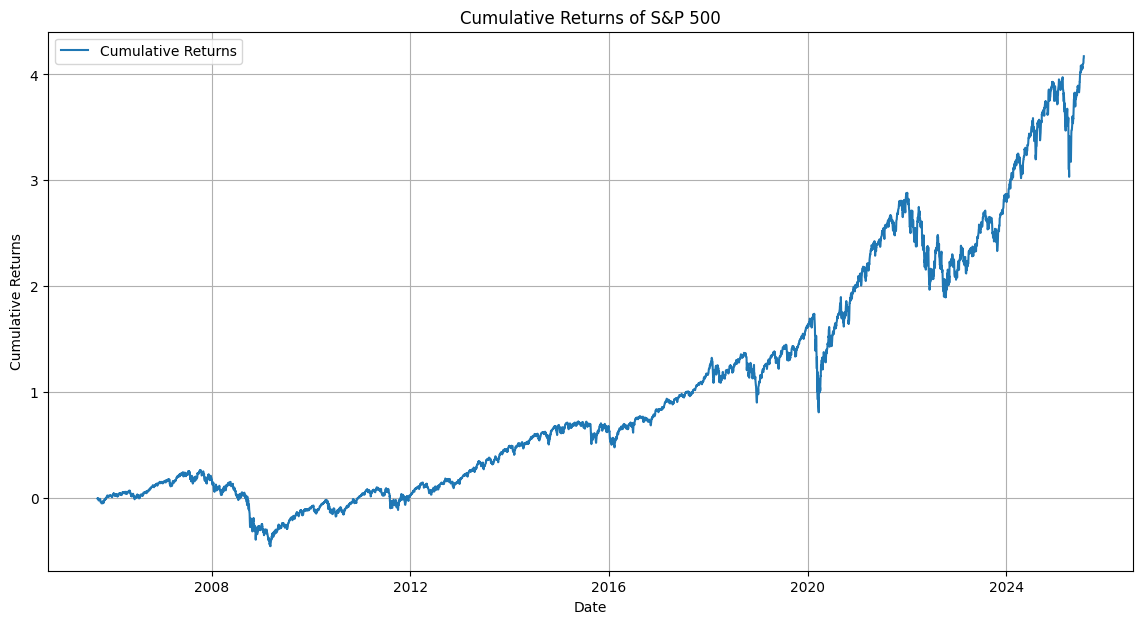

In [69]:
plt.figure(figsize=(14, 7))
plt.plot(df['Cumulative Returns'], label='Cumulative Returns')
plt.title('Cumulative Returns of S&P 500')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid()
plt.show()

Now, let's take a look at the run-up and drawdown graphs:

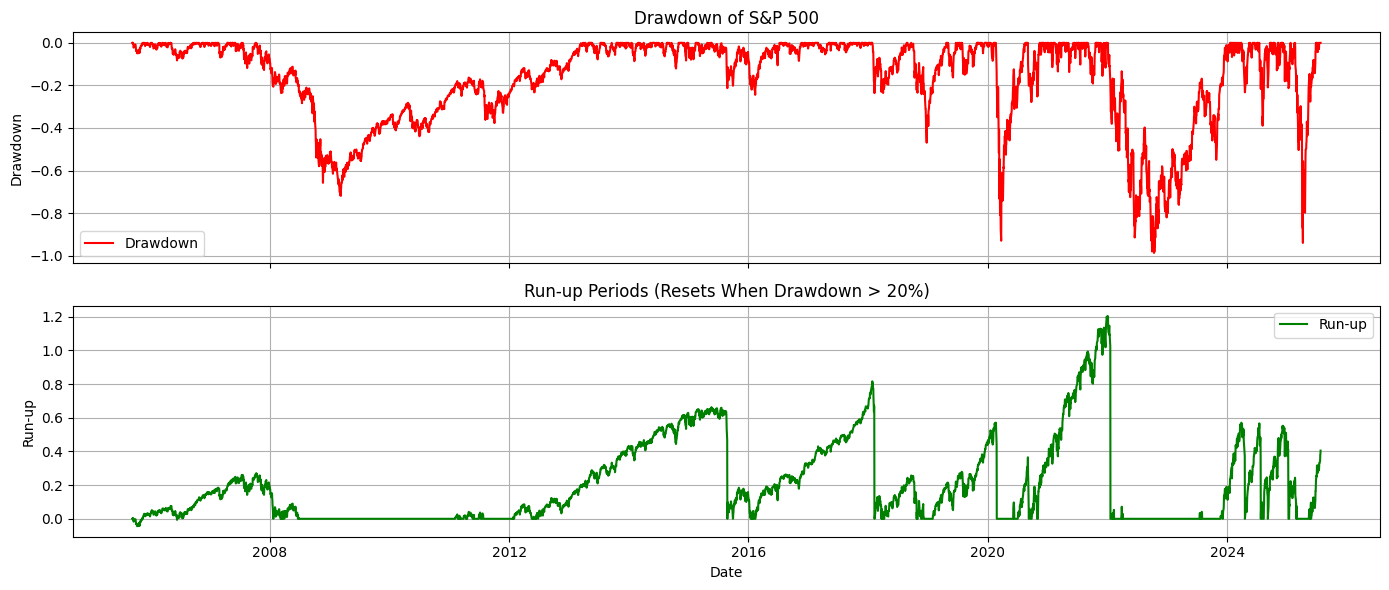

In [70]:
# Calculate Drawdown
df['Drawdown'] = df['Cumulative Returns'] - df['Cumulative Returns'].cummax()

# Calculate Run-up (resetting on drawdown >= 20%)
threshold = -0.20  # 20% drawdown
run_up = []
peak_index = df['Cumulative Returns'].idxmax()
current_base = df['Cumulative Returns'].iloc[0]

for i in range(len(df)):
    if df['Drawdown'].iloc[i] <= threshold:
        current_base = df['Cumulative Returns'].iloc[i]  # reset base
        peak_index = df.index[i]  # mark new peak start
    
    run_up_val = df['Cumulative Returns'].iloc[i] - current_base
    run_up.append(run_up_val)

df['Run-up'] = run_up

# Plot Drawdown and Run-up
fig, axs = plt.subplots(2, 1, figsize=(14, 6), sharex=True)

# Plot 1: Drawdown
axs[0].plot(df.index, df['Drawdown'], color='red', label='Drawdown')
axs[0].set_title('Drawdown of S&P 500')
axs[0].set_ylabel('Drawdown')
axs[0].legend()
axs[0].grid(True)

# Plot 2: Run-up
axs[1].plot(df.index, df['Run-up'], color='green', label='Run-up')
axs[1].set_title('Run-up Periods (Resets When Drawdown > 20%)')
axs[1].set_xlabel('Date')
axs[1].set_ylabel('Run-up')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

This data isn't particularly significant by itself, and it'd be helpful to look at the data in relation to market regimes and cumulative returns. 

To categorise the historical data into the different regimes (bull, bear), we can either use the official definitions (drawdown <= -20% for bear start, run-up >= 20% for bull start) or try to classify them using statistical methods. Here, I'll opt to classify the data via hidden markov models (HMM). 

In [71]:
from hmmlearn.hmm import GaussianHMM
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Prepare features and cumulative return
df_plot = df[['Log Return', 'Volatility', 'Cumulative Returns']].dropna().copy() # Drop rows with NaN values without affecting the original df

# Step 2: Standardize features and fit HMM
X = df_plot[['Log Return', 'Volatility']].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

model = GaussianHMM(n_components=3, covariance_type='full', n_iter=1000, random_state=42)
model.fit(X_scaled)

# Step 3: Predict hidden states and assign to df
df_plot['Regime'] = model.predict(X_scaled)

# Step 4: Summarize regime statistics
for i in range(model.n_components):
    mask = df_plot['Regime'] == i
    mean_ret = df_plot.loc[mask, 'Log Return'].mean()
    vol = df_plot.loc[mask, 'Log Return'].std()
    print(f"Regime {i}: Mean Return = {mean_ret:.5f}, Volatility = {vol:.5f}")


Regime 0: Mean Return = 0.00051, Volatility = 0.00917
Regime 1: Mean Return = 0.00058, Volatility = 0.00568
Regime 2: Mean Return = -0.00035, Volatility = 0.02104


Given the above hidden states, we can deduce that `Regime 2` is **a bear market**, since it is the only regime with a negative mean return. It also has a high volatility, indicating market uncertainty characteristic of a bear market.

Given that `Regime 1` has a slightly higher mean return and a significantly lower volatility compared to `Regime 0`, it is more likely to be **a bull market** as it is characteristic with the high confidence in the market. It is expected that `Regime 0`, being **a neutral market**, would still have a positive mean return since stock prices always tend to increase, and the higher volatility than the bull regime still suggests investor indecision and macro noise.

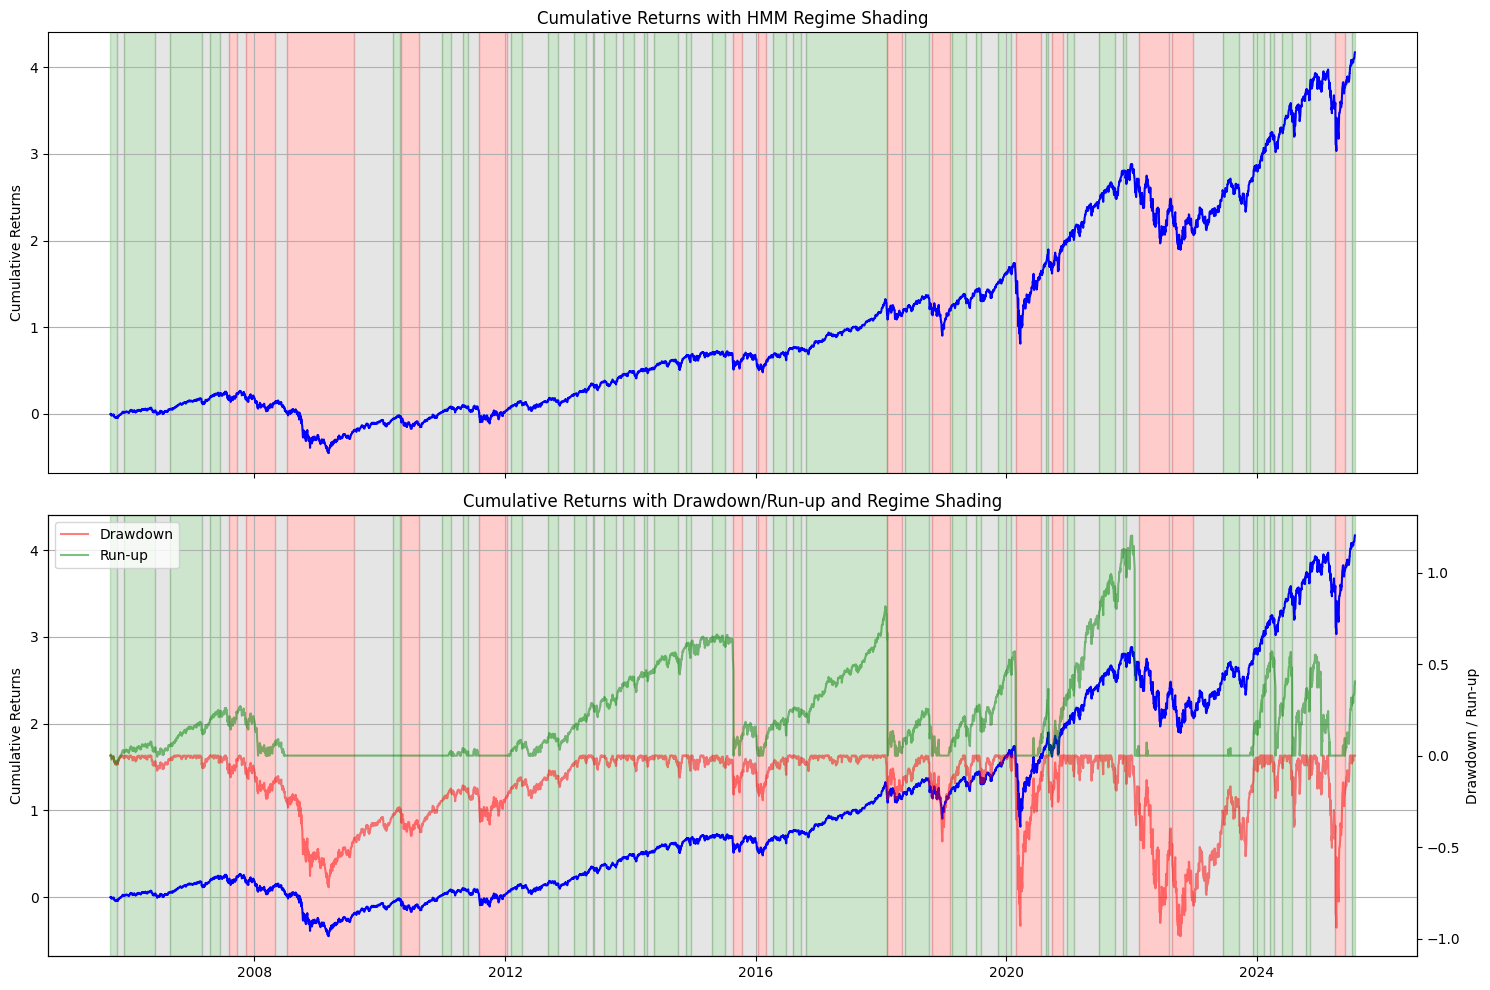

In [72]:
# Regime colors for plotting
regime_colors = {0: 'grey', 1: 'green', 2: 'red'}

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), sharex=True, gridspec_kw={'height_ratios': [1, 1]})

# === Top: Cumulative Returns only ===
ax1.plot(df_plot.index, df_plot['Cumulative Returns'], color='blue', label='Cumulative Returns')
ax1.set_ylabel("Cumulative Returns")
ax1.set_title("Cumulative Returns with HMM Regime Shading")
ax1.grid(True)

# Regime shading
current_regime = None
start_date = None
for date, regime in zip(df_plot.index, df_plot['Regime']):
    if regime != current_regime:
        if current_regime is not None:
            ax1.axvspan(start_date, date, color=regime_colors[current_regime], alpha=0.2)
        current_regime = regime
        start_date = date
ax1.axvspan(start_date, df_plot.index[-1], color=regime_colors[current_regime], alpha=0.2)

# === Bottom: Same plot with secondary axis ===
ax2.plot(df_plot.index, df_plot['Cumulative Returns'], color='blue', label='Cumulative Returns')
ax2.set_ylabel("Cumulative Returns")
ax2.set_title("Cumulative Returns with Drawdown/Run-up and Regime Shading")
ax2.grid(True)

# Regime shading again
current_regime = None
start_date = None
for date, regime in zip(df_plot.index, df_plot['Regime']):
    if regime != current_regime:
        if current_regime is not None:
            ax2.axvspan(start_date, date, color=regime_colors[current_regime], alpha=0.2)
        current_regime = regime
        start_date = date
ax2.axvspan(start_date, df_plot.index[-1], color=regime_colors[current_regime], alpha=0.2)

# Secondary y-axis
ax2b = ax2.twinx()
ax2b.plot(df_plot.index, df.loc[df_plot.index, 'Drawdown'], color='red', label='Drawdown', alpha=0.5)
ax2b.plot(df_plot.index, df.loc[df_plot.index, 'Run-up'], color='green', label='Run-up', alpha=0.5)
ax2b.set_ylabel("Drawdown / Run-up")
ax2b.legend(loc='upper left')

# Improve layout
fig.align_ylabels()  # Align y-labels to avoid shifting
plt.tight_layout()
plt.show()


Having obtained these graphs, we can see the intuitive relationship between how prices correlate to the different market regimes. What we're more interested in now is trying to predict market regimes.

Market regimes directly reflect investor confidence, hence to predict market regime changes ahead of time, we can look at proxies for investor confidence, or even looking out for signals that would impact investor confidence.

There's a lot we can do for that, but the first thing that comes to mind would be to track financial news. This is probably the simplest metric we can use.

In [ ]:
import pandas as pd
from google.cloud import bigquery
from datetime import datetime, timedelta

# Set your GCP project ID here
PROJECT_ID = 'your-gcp-project-id'
YEARS_BACK = 20  # change this to your desired lookback

# Compute date range
end_date = datetime.today()
start_date = end_date - timedelta(days=YEARS_BACK * 365)
start_str = start_date.strftime('%Y%m%d') + '000000'
end_str = end_date.strftime('%Y%m%d') + '000000'

# BigQuery client
client = bigquery.Client(project=PROJECT_ID)

# Query for enriched sentiment features
query = f"""
SELECT
  DATE(TIMESTAMP_MICROS(CAST(RecordDate * 1000 AS INT64))) AS date,
  COUNT(*) AS article_count,
  AVG(CAST(SPLIT(Tone, ',')[OFFSET(0)] AS FLOAT64)) AS avg_tone,
  STDDEV(CAST(SPLIT(Tone, ',')[OFFSET(0)] AS FLOAT64)) AS tone_std,
  MAX(CAST(SPLIT(Tone, ',')[OFFSET(0)] AS FLOAT64)) AS max_tone,
  MIN(CAST(SPLIT(Tone, ',')[OFFSET(0)] AS FLOAT64)) AS min_tone,
  AVG(CAST(SPLIT(Tone, ',')[OFFSET(0)] > 1.5 AS INT64)) AS pct_positive,
  AVG(CAST(SPLIT(Tone, ',')[OFFSET(0)] < -1.5 AS INT64)) AS pct_negative
FROM
  `gdelt-bq.gdeltv2.gkg`
WHERE
  (Themes LIKE '%ECON%' OR Themes LIKE '%MARKET%' OR Themes LIKE '%BANK%' OR Themes LIKE '%FED%')
  AND RecordDate BETWEEN {start_str} AND {end_str}
GROUP BY date
ORDER BY date
"""

# Run query and export to DataFrame
print("Running BigQuery...")
df = client.query(query).to_dataframe()

# Save to CSV
output_path = f"gdelt_sentiment_last_{YEARS_BACK}_years.csv"
df.to_csv(output_path, index=False)
print(f"Saved sentiment data to: {output_path}")


DefaultCredentialsError: Your default credentials were not found. To set up Application Default Credentials, see https://cloud.google.com/docs/authentication/external/set-up-adc for more information.